In [1]:
#Reference: Heng CherKeng https://storage.googleapis.com/kaggle-forum-message-attachments/345216/9642/train.py
    
import os
from trackml.score  import score_event
from sklearn.cluster.dbscan_ import dbscan
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from keras import models
from keras import layers
from keras.layers import Masking
from keras import optimizers


TRAIN_DATA = '../../../input/train_1'

Using TensorFlow backend.


In [434]:
def load_one_event_data(event_id):
    
    particles = pd.read_csv(os.path.join(TRAIN_DATA, 'event%s-particles.csv'%event_id))
    hits  = pd.read_csv(os.path.join(TRAIN_DATA, 'event%s-hits.csv' %event_id))
    truth = pd.read_csv(os.path.join(TRAIN_DATA, 'event%s-truth.csv'%event_id))
    cells = pd.read_csv(os.path.join(TRAIN_DATA, 'event%s-cells.csv'%event_id))

    truth = truth.merge(hits,       on=['hit_id'],      how='left')
    truth = truth.merge(particles,  on=['particle_id'], how='left')

    #--------------------------------------------------------
    df = truth
    return (df)

#TODO x,y,z<0
def generate_train_batch(df, desired_length):
     # ..........................................
    # use volume feature in "x,y,z > 0" only
    df = df.copy()
    #df = df.loc[ (df.x>0) & (df.y>0) & (df.z>0) ]
    df = df.assign(r   = np.sqrt( df.x**2 + df.y**2))
    #df = df.assign(d   = np.sqrt( df.x**2 + df.y**2 + df.z**2 ))
    df = df.assign(a   = np.arctan2(df.y, df.x))
    #df = df.assign(cosa= np.cos(df.a))
    #df = df.assign(sina= np.sin(df.a))
    #df = df.assign(phi = np.arctan2(df.z, df.r))
    #N  = len(df)
    df['z_abs'] = df.z.abs()

    #a,r,z = df[['a', 'r', 'z' ]].values.astype(np.float32).T
    a,r,z,z_abs,v,l,m,x,y = df[['a', 'r', 'z', 'z_abs', 'volume_id', 'layer_id', 'module_id', 'x', 'y' ]].values.astype(np.float32).T
    #x,y,z,z_abs,v,l,m = df[['x', 'y', 'z', 'z_abs', 'volume_id', 'layer_id', 'module_id']].values.astype(np.float32).T
    p = df['particle_id'].values.astype(np.int64)
    
    particle_ids = list(df.particle_id.unique())
    #num_particle_ids = len(particle_ids)
    
    #input  = np.column_stack((a, r/1000, z/3000, v/100, l/100, m/30000))
    #input  = np.column_stack((a, r/1000, z/3000, v, l, m, x, y))
    input  = np.column_stack((x, y, z, v, l, m, a, r, z/r))
    #input = np.column_stack((x/1000, y/1000, z/3000, v/10, l/10, m/3000))
    tracks = []
    
    #desired_length = 9
    for particle_id in particle_ids:
        if particle_id==0: continue
        t = np.where(p==particle_id)[0]
        #t = t[np.argsort(r[t])]
        t = t[np.argsort(z_abs[t])]

        #TODO 
        #if len(t)<10: continue
        #track = input[t[:10]]
        if not len(t) == desired_length: continue
        track = input[t[:desired_length]]
        tracks.append(track)

    tracks = np.array(tracks)
    #input  = tracks[:,:5,:]
    #input = np.pad(input, ((0,0),(0,5), (0,0)), 'constant')
    input = tracks[:,:,:]
    truth  = tracks[:,:,:]

    return (df, input, truth)




In [3]:
def batch_generator(input, truth, batch_size):
    # Create empty arrays to contain batch of features and labels#
    #batch_features = np.zeros((batch_size, input.shape[0], input.shape[1]))
    #batch_labels =  np.zeros((batch_size, truth.shape[0], truth.shape[1]))
    batch_features = np.zeros((batch_size, 3, input.shape[2]))
    batch_labels =  np.zeros((batch_size, 3, truth.shape[2]))
    index = 0
   
    while True:
        #    batch_features = input[batch_size*index:batch_size*(index+1),:,:]
        #    batch_labels = truth[batch_size*index:batch_size*(index+1),:,:]
        #    index = index+1
        #    if batch_size*index > input.shape[0]:
        #        index=0
        for i in range(batch_size):
            batch_features[i,:,:] = input[index,0:3,:]
            batch_labels[i,:,:] = input[index,1:4,:]
            index = index + 1
            if index >= input.shape[0]:
                index = 0
                
        #for i in range(int(batch_size/5)):
        #    for n in range(5):
        #        #print('AAA')
        #        #print(input.shape)
        #        #print('BBB')
        #        #print(batch_features.shape)
        #        #print('CCC')
        #        batch_features[(i*5)+n,:,:] = input[index,n:n+5,:]
        #        batch_labels[(i*5)+n,:,:] = input[index,n+1:n+6,:]
        #    index = index+1
        #    if index >= input.shape[0]:
        #        index=0
      
        yield batch_features, batch_labels



In [4]:
#sgd = optimizers.SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)
#adam =  optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
def build_model(num_hidden, input_shape, output_shape,
                loss='mse',
                optimizer='adam', metrics=['accuracy']):
    
    inputs = layers.Input(shape=input_shape)
    hidden = layers.LSTM(units=num_hidden, return_sequences=True)(inputs)
    outputs = layers.TimeDistributed(layers.Dense(output_shape[1], activation='linear'))(hidden)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [5]:
def draw_train_history(history, draw_val=True, figsize=(12,5)):
    """Make plots of training and validation losses and accuracies"""
    fig = plt.figure(figsize=figsize)
    # Plot loss
    plt.subplot(121)
    plt.plot(history.epoch, history.history['loss'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_loss'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.epoch, history.history['acc'], label='Training set')
    if draw_val:
        plt.plot(history.epoch, history.history['val_acc'], label='Validation set')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim((0, 1))
    plt.title('Training accuracy')
    plt.legend(loc=0)
    plt.tight_layout()
    return fig



In [435]:
def draw_prediction(truth, predict, start=0, end=1):
   
    fig1 = plt.figure(figsize=(12,12))
    ax1  = fig1.add_subplot(111, projection='3d')
    fig1.patch.set_facecolor('white')
    ax1.set_xlabel('x', fontsize=16)
    ax1.set_ylabel('y', fontsize=16)
    ax1.set_zlabel('z', fontsize=16)
        

    fig2 = plt.figure(figsize=(12,12))
    ax2  = fig2.add_subplot(111, projection='3d')
    fig2.patch.set_facecolor('white')
    ax2.set_xlabel('a', fontsize=16)
    ax2.set_ylabel('r', fontsize=16)
    ax2.set_zlabel('z', fontsize=16)

    for n in range(start,end,1):
        x, y, z, v, l, m, a, r, zdr = truth[n].T
        #x = r*np.cos(a)
        #y = r*np.sin(a)
        
        ex, ey, ez, ev, el, em, ea, er, ezdr = predict[n].T
        #ex = er*np.cos(ea)
        #ey = er*np.sin(ea)
        
        color = np.random.uniform(0,1,3)
        ax1.plot(ex,ey,ez,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax1.plot(x,y,z,'.-',color = color, markersize=5)
        
        
        ax2.plot(ea,er,ez,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax2.plot(a,r,z,'.-',color = color, markersize=5)
        if n==50: plt.show(1)

def draw_prediction_xyz(truth, predict):
   
    fig1 = plt.figure(figsize=(12,12))
    ax1  = fig1.add_subplot(111, projection='3d')
    fig1.patch.set_facecolor('white')
    ax1.set_xlabel('x', fontsize=16)
    ax1.set_ylabel('y', fontsize=16)
    ax1.set_zlabel('z', fontsize=16)
        

    #fig2 = plt.figure(figsize=(12,12))
    #ax2  = fig2.add_subplot(111, projection='3d')
    #fig2.patch.set_facecolor('white')
    #ax2.set_xlabel('a', fontsize=16)
    #ax2.set_ylabel('r', fontsize=16)
    #ax2.set_zlabel('z', fontsize=16)

    predict_size = len(predict)
    predict_size = 10
    for n in range(0,predict_size,1):
        x, y, z, v, l, m = truth[n].T
        ex, ey, ez, ev, el, em = predict[n].T
        
        color = np.random.uniform(0,1,3)
        ax1.plot(ex,ey,ez,'.-',color = [0.75,0.75,0.75], markersize=10)
        ax1.plot(x,y,z,'.-',color = color, markersize=5)
        
        if n==50: plt.show(1)



   
    

In [273]:
def generate_multiple_event_data(skip=0, nevents=10, length=10):
    start = 1000
    for i in range(nevents):
        df = load_one_event_data('00000' + "{:04}".format(start+skip+i))
        df, input_tmp, truth_tmp = generate_train_batch(df, length)
        if i==0:
            input = input_tmp
            truth = truth_tmp
        else:
            input = np.concatenate([input, input_tmp])
            truth = np.concatenate([truth, truth_tmp])
            
    return input, truth

In [476]:

# Solve for y = mx + b
def solve_single_linear_equation(val1, val2):
    x1 = val1[0]
    x2 = val2[0]
    y1 = val1[1]
    y2 = val2[1]
    is_valid = (x1 != x2 and y1 != y2)
    m = 0
    b = 0
    if is_valid:
        a = np.array([[x1, 1], [x2, 1]])
        b = np.array([y1, y2])
        sol = np.linalg.solve(a, b)
        m = sol[0]
        b = sol[1]
    return is_valid, m, b


def solve_linear_equation(vals):
    """Take average of y=mx+b slope across all pair-wise elements, as well as between
       first and last elements."""
    m = 0
    b = 0
    count = 0
    for i in range(len(vals) - 1):
        is_valid, m2, b2 = solve_single_linear_equation(vals[i], vals[i+1])
        if is_valid:
            count = count + 1
            m = m + m2
            b = b + b2
    is_valid, m2, b2 = solve_single_linear_equation(vals[0], vals[-1])
    if is_valid:
        count = count + 1
        m = m + m2
        b = b + b2
    if count > 1:
        m = m / count
        b = b / count
    return m, b


def is_track_straight(vals, m, b):
    # m/b solved for vals[0], vals[1], test with others
    xdiffs = []
    ydiffs = []
    is_reject = 0
    is_straight = 1
    outlier_count = 0
    y_sum = abs(np.sum(vals[:,1]))
    for ix, val in enumerate(vals):
        yhat = m * val[0] + b
        ydiff = abs(yhat - val[1])
        ydiffs.append(ydiff)
        #print('yhat: ' + str(yhat) + ', y: ' + str(val[1]) + ', diff: ' + str(ydiff))
        xhat = (val[1] - b) / m
        xdiff = abs(xhat - val[0])
        xdiffs.append(xdiff)
        #print('xhat: ' + str(xhat) + ', x: ' + str(val[0]) + ', diff: ' + str(xdiff))
        #print('Diff at ix ' + str(ix) + ' is: ' + str(diff))
        if (ydiff > 3 and ydiff > abs(val[1]*0.3)):
            outlier_count = outlier_count + 1
            is_straight = 0
            if (ydiff > abs(val[1]*0.5)):
                is_reject = 1
    #print(str(is_straight) + ', ' + str(y_sum) + ', ' + str(sum(ydiffs)))
    # Tolerate a single outlier if the total diff is minimal
    if outlier_count == 1 and is_reject == 0 and sum(ydiffs) <= y_sum*0.05:
        is_straight = 1
        #print('Straightened!')
    return is_straight, xdiffs, ydiffs

def is_track_straight_zr(vals):
    zr_values = vals[:,8]
    min_zr = zr_values.min()
    max_zr = zr_values.max()
    median_zr = np.median(zr_values)
    allowed_min = median_zr * 0.8
    allowed_max = median_zr * 1.2
    is_straight = ((min_zr >= allowed_min) and (max_zr <= allowed_max))
    if is_straight:
        print(zr_values)
        print('min: ' + str(min_zr) + ', max: ' + str(max_zr) + ', med: ' + str(median_zr) + ', amin: ' + str(allowed_min) + ', amax: ' + str(allowed_max))
    return is_straight

In [ ]:
for length in range(4, 18, 1):
    lfi, lft = generate_multiple_event_data(skip=200, nevents=1, length=length)
    straight_tracks = []
    for i in range(start, end, 1):
        m, b = solve_linear_equation(lfi[i])
        is_straight, xdiffs, ydiffs = is_track_straight(lfi[i], m, b)
        #print(str(i) + ': ' + str(is_straight) + ', ' + str(xdiffs) + ', ' + str(ydiffs) + ', ' + str(lfi[i,:,3]) + ', ' + str(lfi[i,:,4]) + ', ' + str(lfi[i,:,5]))
        total_straight = total_straight + is_straight
        if is_straight == 1:
            #print(str(i) + ': ' + str(is_straight) + ', ' + str(xdiffs) + ', ' + str(ydiffs) + ', ' + str(lfi[i,:,3]) + ', ' + str(lfi[i,:,4]) + ', ' + str(lfi[i,:,5]))
            straight_tracks.append(lfi[i])
        else:
            helix_tracks.append(lfi[i])
print('Total straight tracks: ' + str(total_straight))

In [474]:
lfi, lft = generate_multiple_event_data(skip=200, nevents=1, length=10)
print(lfi.shape)

(947, 10, 9)


Total straight tracks: 160


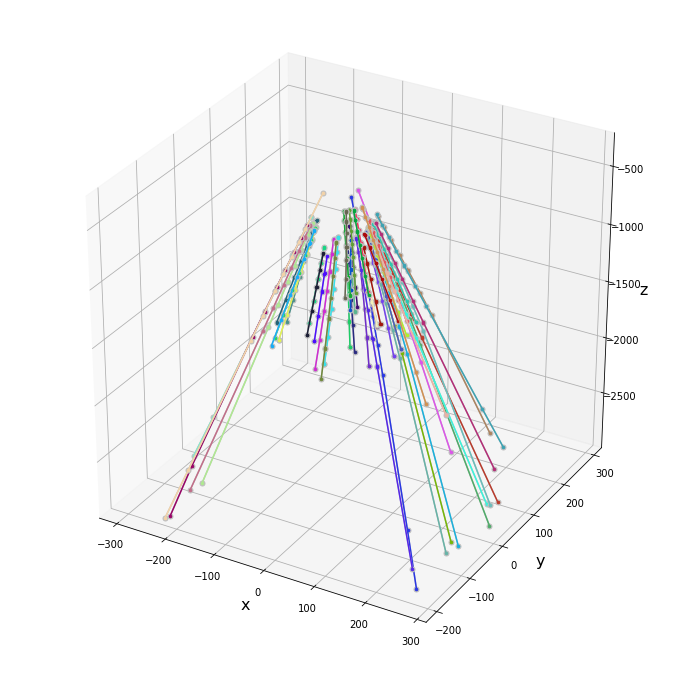

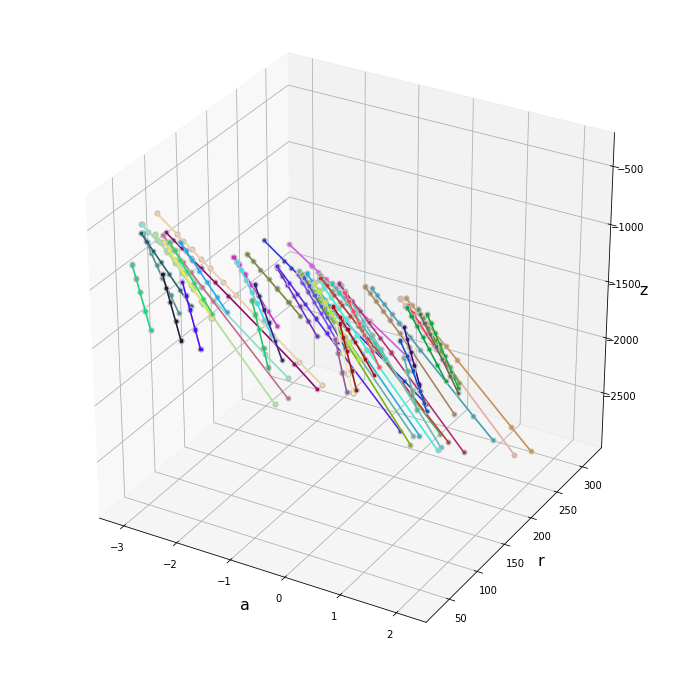

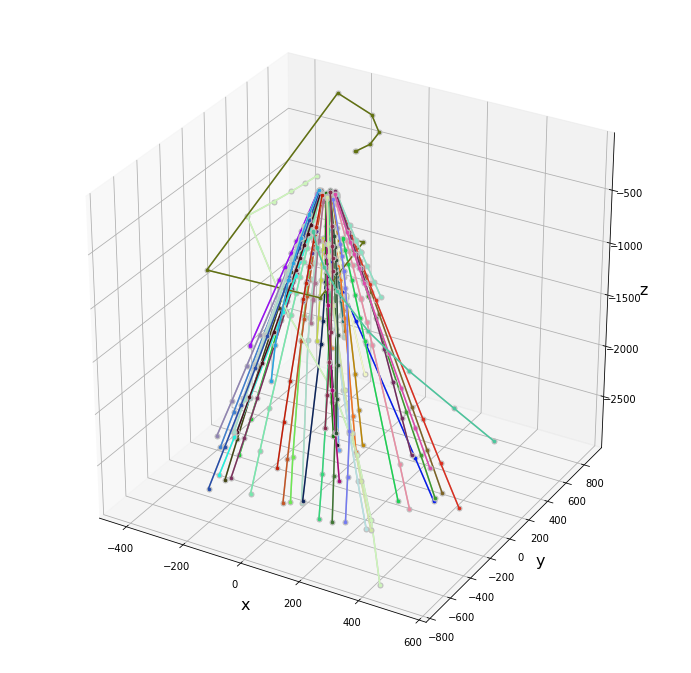

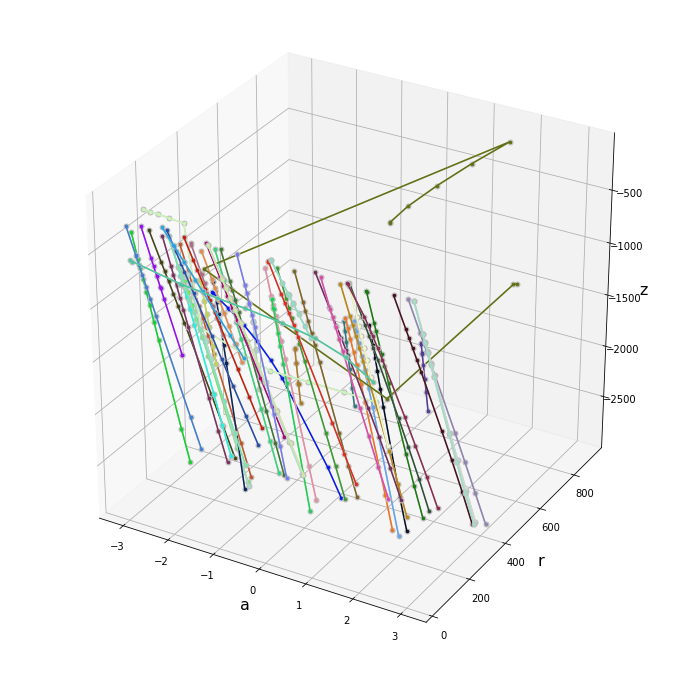

In [479]:
start = 0
end = start + lfi.shape[0]
total_straight = 0
straight_tracks = []
helix_tracks = []
for i in range(start, end, 1):
    m, b = solve_linear_equation(lfi[i])
    is_straight, xdiffs, ydiffs = is_track_straight(lfi[i], m, b)
    #print(str(i) + ': ' + str(is_straight) + ', ' + str(xdiffs) + ', ' + str(ydiffs) + ', ' + str(lfi[i,:,3]) + ', ' + str(lfi[i,:,4]) + ', ' + str(lfi[i,:,5]))
    #is_straight = is_track_straight_zr(lfi[i])
    total_straight = total_straight + is_straight
    if is_straight == 1:
        #x, y, z, v, l, m, a, r, zdr = truth[n].T
        #print(str(i) + ': ' + str(is_straight) + ', ' + str(xdiffs) + ', ' + str(ydiffs) + ', ' + str(lfi[i,:,3]) + ', ' + str(lfi[i,:,4]) + ', ' + str(lfi[i,:,5]))
        #print(str(i) + ': ' + str(is_straight) + ', ' + str(lfi[i,:,8]))
        straight_tracks.append(lfi[i])
        #if total_straight > 3:
        #    break
    else:
        helix_tracks.append(lfi[i])
print('Total straight tracks: ' + str(total_straight))

#ix = 4
#m, b = solve_linear_equation(lfi[ix])
#is_straight, xdiffs, ydiffs = is_track_straight(lfi[ix], m, b)
#print(str(ix) + ': ' + str(is_straight) + ', ' + str(xdiffs) + ', ' + str(ydiffs) + ', ' + str(lfi[ix,:,1]) + ', ' + str(lfi[ix,:,3]) + ', ' + str(lfi[ix,:,4]) + ', ' + str(lfi[ix,:,5]))
#straight_tracks.append(lfi[4])
# 4-length: few start in 7, many start in 8 (2), many start in 13
# 5-length: few start in 7, many start in 8 (2), many start in 13
#print(lfi[start,:,:])
#print(lft[start])
#draw_prediction(lft, lfi, start, end)

draw_prediction(straight_tracks, straight_tracks, 0, len(straight_tracks))
draw_prediction(helix_tracks, helix_tracks, 0, len(helix_tracks))


In [39]:
if __name__ == '__main__':


    input, truth = generate_multiple_event_data(skip=200, nevents=320)
    val_input, val_truth = generate_multiple_event_data(skip=100, nevents=20)
    
    test_df = load_one_event_data('000001090')
    test_df, test_input, test_truth = generate_train_batch(test_df)
    
    
    print(input.shape)
    print(truth.shape)
    

(351686, 4, 4)
(351686, 4, 4)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3, 4)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 3, 96)             38784     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 3, 4)              388       
Total params: 39,172
Trainable params: 39,172
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7033/7033 [==============================] - 67s 10ms/step - loss: 0.0045 - acc: 0.9554 - val_loss: 0.0022 - val_acc: 0.9654
Epoch 2/100
7033/7033 [==============================] - 70s 10ms/step - loss: 0.0022 - acc: 0.9661 - val_loss: 0.0024 - val_acc: 0.9695
Epoch 3/100
7033/7033 [==============================] - 70s 10ms/step - loss: 0.0021 - acc: 0.9676 - val_loss: 0.0018 - val_acc

7033/7033 [==============================] - 66s 9ms/step - loss: 0.0016 - acc: 0.9754 - val_loss: 0.0021 - val_acc: 0.9655
Epoch 56/100
7033/7033 [==============================] - 66s 9ms/step - loss: 0.0016 - acc: 0.9753 - val_loss: 0.0012 - val_acc: 0.9766
Epoch 57/100
7033/7033 [==============================] - 66s 9ms/step - loss: 0.0016 - acc: 0.9755 - val_loss: 0.0020 - val_acc: 0.9716
Epoch 58/100
7033/7033 [==============================] - 66s 9ms/step - loss: 0.0016 - acc: 0.9752 - val_loss: 0.0016 - val_acc: 0.9729
Epoch 59/100
7033/7033 [==============================] - 67s 9ms/step - loss: 0.0016 - acc: 0.9754 - val_loss: 0.0018 - val_acc: 0.9689
Epoch 60/100
7033/7033 [==============================] - 66s 9ms/step - loss: 0.0016 - acc: 0.9754 - val_loss: 0.0018 - val_acc: 0.9724
Epoch 61/100
7033/7033 [==============================] - 66s 9ms/step - loss: 0.0016 - acc: 0.9755 - val_loss: 0.0012 - val_acc: 0.9740
Epoch 62/100
7033/7033 [==============================

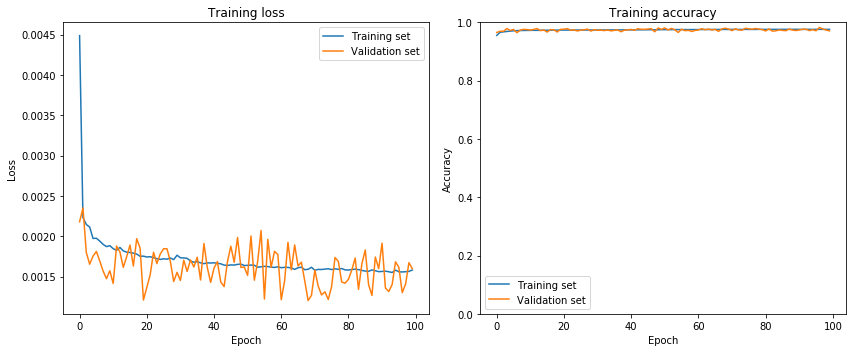

In [41]:
batch_size = 50
num_epoch = 100
model = build_model(num_hidden=96, input_shape=(3,4), output_shape=(3,4))

model.summary()

generator = batch_generator(input, truth, batch_size)
val_generator = batch_generator(val_input, val_truth, batch_size)
# Train the model
history = model.fit_generator(generator, validation_data=val_generator,validation_steps=int((val_input.shape[0])/batch_size),
                              steps_per_epoch=int((input.shape[0])/batch_size), epochs=num_epoch, 
                              shuffle = False)
#val_generator = (val_input, val_truth, batch_size)
# Train the model
#history = model.fit_generator(generator, validation_data=(val_input, val_truth),
#                              steps_per_epoch=int(input.shape[0]/batch_size), epochs=num_epoch, 
#                              shuffle = False)
#
#history = model.fit_generator(generator, validation_data=(val_input[:,0:5,:], val_truth[:,1:6,:]),
#                              steps_per_epoch=int(input.shape[0]), epochs=num_epoch, 
#                              shuffle = False)

# 5 epochs, 24 hidden, loss=0.000973, acc: 0.9791, val_loss: 0.0011, val_acc: 0.9777
# 3 epochs, 96 hidden, loss=0.00094, acc: 0.9796, val_loss: 0.0012, val_acc: 0.9775
# 10 epochs, 96 hidden, loss=0.0008, acc: 0.9814, val_loss: 0.00096, val_acc: 0.9781
# 3 epochs, 48 hidden, 100 dense, loss=0.0010, acc: 0.9777, val_loss: 0.0012, val_acc: 0.9736
# 3 epochs r-sort, 24 hidden, loss=0.0014, acc: 0.9745, val_loss: 0.0014, val_acc: 0.9753
# 24 neurons: Epoch 100 7033/7033 [==] - 59s 8ms/step - loss: 0.0012 - acc: 0.9730 - val_loss: 9.9398e-04 - val_acc: 0.9743
# 48 neurons: Epoch 100 7033/7033 [==] - 66s 9ms/step - loss: 0.0011 - acc: 0.9737 - val_loss: 0.0010 - val_acc: 0.9705
draw_train_history(history, draw_val=True);

In [ ]:
batch_size = 10000
num_epoch = 10
history = model.fit_generator(generator, validation_data=val_generator,validation_steps=int((val_input.shape[0])/batch_size),
                              steps_per_epoch=int((input.shape[0])/batch_size), epochs=num_epoch, 
                              shuffle = False)
draw_train_history(history, draw_val=True)

In [ ]:
batch_size = 250
num_epoch = 10
history = model.fit_generator(generator, validation_data=val_generator,validation_steps=int((5*val_input.shape[0])/batch_size),
                              steps_per_epoch=int((5*input.shape[0])/batch_size), epochs=num_epoch, 
                              shuffle = False)
draw_train_history(history, draw_val=True)

In [ ]:
batch_size = 125
num_epoch = 5
history = model.fit_generator(generator, validation_data=val_generator,validation_steps=int((5*val_input.shape[0])/batch_size),
                              steps_per_epoch=int((5*input.shape[0])/batch_size), epochs=num_epoch, 
                              shuffle = False)
draw_train_history(history, draw_val=True)

In [ ]:
batch_size = 60
num_epoch = 3
history = model.fit_generator(generator, validation_data=val_generator,validation_steps=int((5*val_input.shape[0])/batch_size),
                              steps_per_epoch=int((5*input.shape[0])/batch_size), epochs=num_epoch, 
                              shuffle = False)
draw_train_history(history, draw_val=True)

In [ ]:
batch_size = 5
num_epoch = 1
history = model.fit_generator(generator, validation_data=val_generator,validation_steps=int((5*val_input.shape[0])/batch_size),
                              steps_per_epoch=int((5*input.shape[0])/batch_size), epochs=num_epoch, 
                              shuffle = False)
draw_train_history(history, draw_val=True)

In [42]:
ti = test_input[:,0:3,:]
tt = test_truth[:,1:4,:]
#ti = input[0:20,0:5,:]
#tt = input[0:20,1:6,:]
#pred = model.predict(test_input)
#test_loss, test_acc = model.evaluate(test_input, test_truth)
pred = model.predict(ti)
test_loss, test_acc = model.evaluate(ti, tt)
print(test_loss, test_acc)
    
    

1064/1064 [==============================] - 0s 50us/step
0.00172189636947 0.972117793291


[[ 0.10778568  0.07165624  0.0066493   0.04      ]
 [ 0.0620237   0.11572352  0.01201303  0.06      ]
 [ 0.00814392  0.17078567  0.0187465   0.08      ]]
[[ 0.1424908   0.06807877  0.0103963   0.03750057]
 [ 0.0577575   0.10169919  0.00790179  0.05221708]
 [ 0.00996643  0.14572063  0.00506803  0.07333   ]]


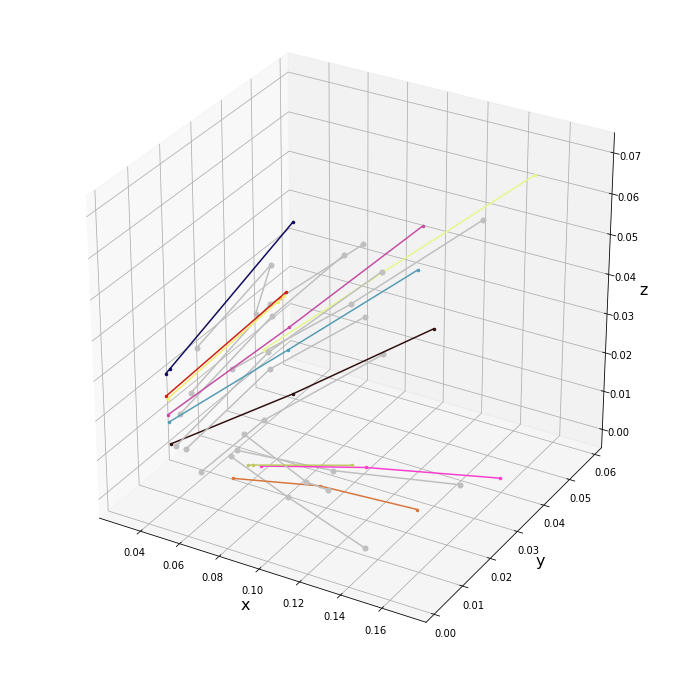

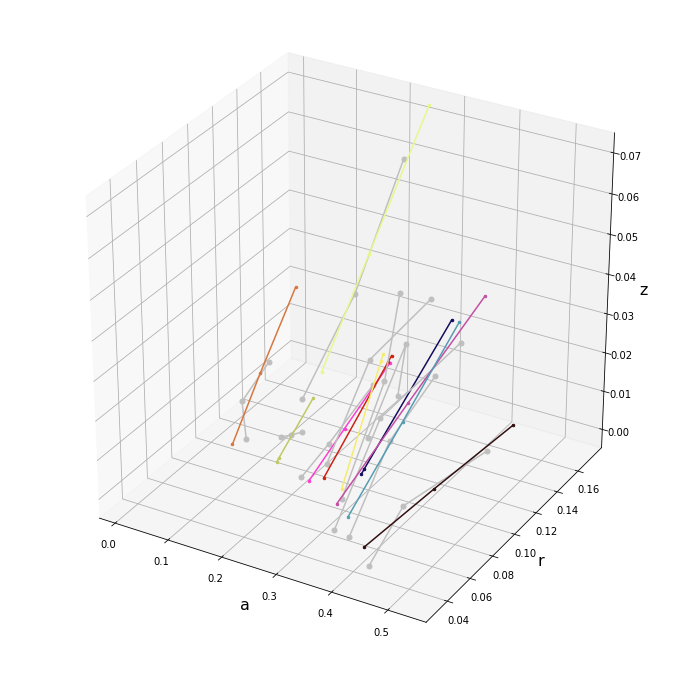

In [43]:
#print(test_truth[1])
#print(tt[1])
#print(pred[1])
   
#draw_prediction(test_truth, pred)
start = 20
end = start + 10
print(tt[start])
print(pred[start])
draw_prediction(tt, pred, start, end)
